In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import nengo
import nengo_spa as spa

from ssp.maps import Spatial2D
from ssp.pointers import BaseVectors

In [3]:
# Adaoted from ssp_grid_cell_utils.py and ssp_grid_cell_examples.ipynb
# Accurate representation for spatial cognition using grid cells
# Nicole Sandra-Yaffa Dumont & Chris Eliasmith

def ssp_plane_basis(K):
    # Create the bases vectors X,Y as described in the paper with the wavevectors 
    # (k_i = (u_i,v_i)) given in a matrix K. To get hexganal patterns use 3 K vectors 120 degs apart
    # To get mulit-scales/orientation, give many such sets of 3 K vectors 
    # K is _ by 2 
    d = K.shape[0]
    FX = np.ones((d*2 + 1,), dtype="complex")
    FX[0:d] = np.exp(1.j*K[:,0])
    FX[-d:] = np.flip(np.conj(FX[0:d]))
    FX = np.fft.ifftshift(FX)
    FY = np.ones((d*2 + 1,), dtype="complex")
    FY[0:d] = np.exp(1.j*K[:,1])
    FY[-d:] = np.flip(np.conj(FY[0:d]))
    FY = np.fft.ifftshift(FY)
    
    X = spa.SemanticPointer(data=np.fft.ifft(FX))
    Y = spa.SemanticPointer(data=np.fft.ifft(FY))
    return X, Y


def generate_grid_cell_basis(n_scales, n_rotates, scale_min=0.5, scale_max=1.8):
    """Generates basis vectors with ``d = n_scales * n_rotates * 6 + 1``."""
    K_hex = np.array(
        [[0, 1],
         [np.sqrt(3) / 2, -0.5],
         [-np.sqrt(3) / 2, -0.5]]
    )

    # Combining multiple n_scales sets of 3 wave vectors that give hexagonal grid interference patterns
    # each set of 3 giving a different grid resolution
    scales = np.linspace(scale_min, scale_max, n_scales)
    K_scales = np.vstack([K_hex * i for i in scales])

    # Combining multiple n_rotates sets of 3 wave vectors that give hexagonal grid interference patterns
    # each set of 3 giving a different grid orientation
    thetas = np.arange(0, n_rotates) * np.pi / (3 * n_rotates)
    R_mats = np.stack([np.stack([np.cos(thetas), -np.sin(thetas)], axis=1),
                       np.stack([np.sin(thetas), np.cos(thetas)], axis=1)],
                      axis=1)
    # TODO: don't double transpose
    K_rotates = (R_mats @ K_hex.T).transpose(1, 2, 0).T.reshape(-1, 2)

    # Multiple resolutions and orientations
    # TODO: don't double transpose
    K_scale_rotates = (R_mats @ K_scales.T).transpose(1, 2, 0).T.reshape(-1, 2)

    # Generate the (X, Y) basis vectors
    X, Y = ssp_plane_basis(K_scale_rotates)
    d = n_scales * n_rotates * 6 + 1
    assert len(X) == len(Y) == d
    return X, Y, d

In [4]:
X, Y, d = generate_grid_cell_basis(n_scales=5, n_rotates=5,
                                   scale_min=0.9, scale_max=1.5)
print("Dimensionality:", d)

Dimensionality: 151


/home/arvoelke/git/spa/nengo_spa/semantic_pointer.py:57: ComplexWarning: Casting complex values to real discards the imaginary part
  self.v = np.array(data, dtype=float)


In [5]:
rng = np.random.RandomState(seed=0)
vocab = spa.Vocabulary(d, pointer_gen=BaseVectors(d, rng=rng))
vocab.populate('X;Y')
X = vocab['X']
Y = vocab['Y']

def lnsp(x):
    return np.fft.ifft(np.log(np.fft.fft(x))).real

lnX = spa.SemanticPointer(np.fft.ifft(np.log(np.fft.fft(X.v))).real)
lnY = spa.SemanticPointer(np.fft.ifft(np.log(np.fft.fft(Y.v))).real)

In [6]:
radius = 5  # in SSP space
freq = 0.2
v_scale = 2 * np.pi * freq * radius
x_func = lambda t: -np.sin(2 * np.pi * freq * t)
y_func = lambda t: np.cos(2 * np.pi * freq * t)
tau = 0.1

# Network definition adapted from Terry Stewart's example (used with permission)
with nengo.Network(seed=0) as model:
    model.config[nengo.Ensemble].neuron_type = nengo.SpikingRectifiedLinear()  # nengo.Direct()

    path = spa.networks.CircularConvolution(n_neurons=100, dimensions=d)
    
    # do the "+x" part of principle 3
    # it is also possible to do this directly within the product network,
    # but we want to be able to initialize and probe path.input_a.
    transform = spa.networks.circularconvolution.transform_out(d)
    inner_a = nengo.Node(None, size_in=transform.shape[1])
    nengo.Connection(path.product.sq1.output, inner_a, synapse=None)
    nengo.Connection(path.product.sq2.output, inner_a, synapse=None)
    # compute the transform required to undo the DFT[a] by determining what
    # happens when input_b is a delta
    transform_b = spa.networks.circularconvolution.transform_in(d, "B", False)
    identity = np.zeros(d)
    identity[0] = 1.
    identity_mask = transform_b.dot(identity)
    transform_a_inv = transform * identity_mask[None, :]
    nengo.Connection(inner_a, path.input_a, transform=transform_a_inv / np.sqrt(2), synapse=tau)

    # do the "tau*dSSP" part of principle 3
    conn = nengo.Connection(path.output, path.input_a, transform=v_scale * tau, synapse=tau)

    # do the input
    stim_x = nengo.Node(x_func)    
    nengo.Connection(stim_x, path.input_b, transform=lnX.v[:, None], synapse=None)
    stim_y = nengo.Node(y_func)    
    nengo.Connection(stim_y, path.input_b, transform=lnY.v[:, None], synapse=None)
    
    p = nengo.Probe(path.input_a, synapse=None)

In [7]:
print("Neurons:", sum(ens.n_neurons for ens in model.all_ensembles))

Neurons: 30400


In [8]:
with nengo.Simulator(model) as sim:
    # Note: for this trick to work, conn.synapse needs to be referencing
    # the last connection with this particular tau to be added to the model
    # since it hashes by its contents and not by its identity.
    signal = sim.model.sig[conn.synapse]
    sim.signals[signal['_state_X']] = (X ** radius).v[None, :]

    sim.run(1 / freq)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

In [9]:
ssp_map = Spatial2D(dim=d, scale=14, rng=rng, X=X, Y=Y)
ssp_map.build_grid(x_len=0.5, y_len=0.5, x_spaces=101, y_spaces=101, centered=True)

/home/arvoelke/git/spa/nengo_spa/vocabulary.py:182: UserWarning: Could not create a semantic pointer with max_similarity=0.10 (D=151, M=23, similarity=0.10)
  % (self.max_similarity, self.dimensions, len(self._key2idx), best_sim)


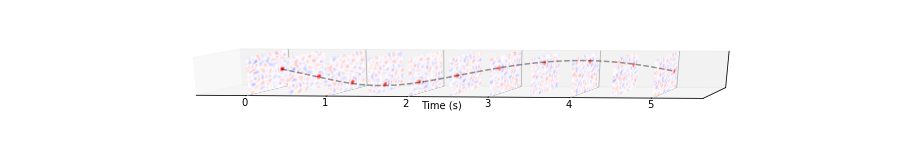

In [10]:
# Adapted from Pete B's example
import scipy.interpolate as si
from mpl_toolkits.mplot3d import axes3d, Axes3D
from matplotlib import cm

n_slices = 11
x = ssp_map.xs
y = ssp_map.ys
X, Y = np.meshgrid(x, y)
cmap = 'bwr'
scam = plt.cm.ScalarMappable(norm=cm.colors.Normalize(-1, 1), cmap=cmap)

fig = plt.figure(figsize=(16, 2.5))
ax = fig.gca(projection='3d')

for t in np.linspace(1, len(sim.trange()) - 1, n_slices, dtype=int):
    c = ssp_map.compute_heatmap(spa.SemanticPointer(sim.data[p][t]))
    Z = np.ones_like(Y) * t * sim.dt
    ax.plot_surface(
        Z, X, Y, facecolors=scam.to_rgba(c), cmap=cmap, vmin=-1, vmax=1,
        antialiased=True, rstride=1, cstride=1, alpha=None,
    )

t = sim.trange()
scale = radius / ssp_map.scale
ax.plot(t, y_func(t) * scale, x_func(t) * scale, linestyle='--',
        color='black', alpha=0.4, zorder=np.inf)
    
ax.set_xlabel("Time (s)", labelpad=25)
ax.set_yticks([])
ax.set_zticks([])

fudge = 0.5
ax.set_xlim(-fudge, sim.trange()[-1] + fudge)

# https://stackoverflow.com/a/30419243
ax.get_proj = lambda: np.dot(Axes3D.get_proj(ax), np.diag([1, 0.5, 0.5, 1]))

ax.view_init(15, -82)
plt.savefig('../figures/oscillator-path-integrator.pdf', bbox_inches='tight')

fig.show()